Advanced Machine Learning Assignment
# Assignment 4: Fully-Connected Networks and Convoluntional Neural Networks


# Section 0 Environment Set Up

In this homework, you will need to use **GPU** to accelerate your training process. Thus, please set up the **runtime type**.

**Runtime -> Change Runtime type -> Hardware Accelerator -> GPU**

In [ ]:
! pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 101kB/s 
ERROR: tensorflow 2.2.0rc2 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


Mount your google drive in google colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Append the directory to your python path using sys.

Please do modify the `customized_path_to_your_homework` to where you uploaded your homework in the Google Drive

In [ ]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'HW4/HW4'
sys_path = os.path.join(prefix, customized_path_to_your_homework)
sys.path.append(sys_path)

# Section 1 Pytorch basics

Simply put, PyTorch is a **Tensor** library like Numpy. These two libraries similarly provide useful and efficient APIs for you to deal with your tensor data. What really differentiate PyTorch from Numpy are the following two features:
1. Numerical operations that can **run on GPUs** (more than 10x speedup)
2. Automatic differentiation for building and training neural networks

In this section, we will walk through some simple example, and see how the automatic differentiation functionality can make your life much easier.

## 1.1. `nn` Module
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In PyTorch, the nn package serves this purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

Now, let's see how our simple NN could be implemented using the nn module.

In [ ]:
import torch
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)


    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

iteration 99: 2.0201845169067383
iteration 199: 0.037375327199697495
iteration 299: 0.00191470084246248
iteration 399: 0.00014480709796771407
iteration 499: 1.2275126209715381e-05


So far, we have been updating the model parameters manually with `torch.no_grad()`. However, if we want to use optimization algorithms other than SGD, it might get a bit nasty to do it manually. Instead of manually doing this, we can use `optim` pacakge to help optimize our model: 

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. 
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iteration 99: 2.1841070652008057
iteration 199: 0.02455112524330616
iteration 299: 0.0006979845929890871
iteration 399: 2.9736311262240633e-05
iteration 499: 1.5952685998854577e-06


Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

For example, we can implement our 2-layer simple NN as the following:

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

iteration 99: 1.9060227870941162
iteration 199: 0.03743543103337288
iteration 299: 0.0018738838844001293
iteration 399: 0.00011590263602556661
iteration 499: 7.802081199770328e-06


# Section 2 Fully-Connected Networks

## 2.1 Dowload Two-moon datasets
Now, let's use PyTorch to solve some synthetic datasets. In previous assignment, we have to write some codes to create training batches. Again, this can also be done with PyTorch `DataLoader`. The `DataLoader` utilizes parallel workers to read and prepare batches for you, which can greatly speedup the code when your time bottleneck is on file I/O.

Here, we show a simple example that can create a dataloader from numpy data:

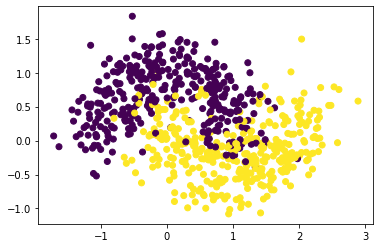

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

current_path = prefix + customized_path_to_your_homework
X_train = np.loadtxt(current_path + '/data/X1_train.csv', delimiter=',')
X_test = np.loadtxt(current_path + '/data/X1_test.csv', delimiter=',')
y_train = np.loadtxt(current_path + '/data/y1_train.csv', delimiter=',')
y_test = np.loadtxt(current_path + '/data/y1_test.csv', delimiter=',')

# Plot it to see why is it called two-moon dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

Now, let's create a PyTorch `DataLoader`:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = True # shuffle the dataset

# Convert numpy array import torch tensor
X_val = torch.FloatTensor(X_train[500:])
X_train = torch.FloatTensor(X_train[:500])
X_test = torch.FloatTensor(X_test)
y_val = torch.LongTensor(y_train.reshape(-1, 1)[500:])
y_train = torch.LongTensor(y_train.reshape(-1, 1)[:500])
y_test = torch.LongTensor(y_test.reshape(-1, 1))

# First, create a dataset from torch tensor. A dataset define how to read data
# and process data for creating mini-batches.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=num_workers, shuffle=shuffle)

Below, we provide a simple example on how to train your model with this dataloader:

In [ ]:
epoch = 5 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well
model = nn.Linear(X_train.size(1), 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    # loop through train loader to get x and y
    for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = (y_pred - y.float()).abs().mean()
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')

Epcoh 0: 6.44906759262085
Epcoh 1: 3.894591748714447
Epcoh 2: 2.7337540090084076
Epcoh 3: 2.27503964304924
Epcoh 4: 2.136403039097786


## 2.2 Your Simple NN [30 pts]
Now, it is time for you to implement your own model for this classification task. Your job here is to:
1. Complete the SimpleNN class. It should be a 2- or 3-layer NN with proper non-linearity.
2. Train your model with SGD optimizer.
3. Tune your model a bit so you can achieve at least 80% accuracy both on training set and validation set.
Hint: you might want to look up `nn.ReLU`, `nn.Sigmoid`, `nn.BCELoss` in the [official document](https://pytorch.org/docs/stable/). You are allowed to freely pick the hyperparameters of your model.

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        self.Sigmoid = nn.Sigmoid()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
      h_relu = self.linear1(x).clamp(min=0)
      y_pred = self.linear2(h_relu)
      y_pred = self.Sigmoid(y_pred)
      return y_pred
        ################################################################################
        # TODO:                                                                        #
        # feed the input to your network, and output the predictions.                  #
        ################################################################################
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()
    y = y.float()
    return (y==pred).sum().float()/y.size(0)*100.

In [ ]:
def Solver(model, train_loader, optim, criterion, epoch=501, lr=1e-1, print_every=20):
  '''
  The solver function for training your model

  model: your designed model
  train_loader: data loader for training data
  optim: SGD optimizer
  criterion: criterion for calculating loss, i.e. nn.BCELoss
  epoch: number of training epochs, an epoch means looping through all the data in the datasets
  lr: training learning rate
  print_every: number of epochs to print out loss and accuracies
  '''
  for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y.float())
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
      ################################################################################
      # TODO:                                                                        #
      # Loop through the dataloader and train your model with nn.BCELoss.            #
      ################################################################################
      
      ################################################################################
      #                                 END OF YOUR CODE                             #
      ################################################################################
      if e % print_every == 0:
          y_pred = (model(X_train) > 0.5)
          train_acc = get_acc(y_pred, y_train)
          y_val_pred = (model(X_val) > 0.5)
          val_acc = get_acc(y_val_pred, y_val)  
          print(f'Epcoh {e}: {loss_epoch}, Training accuracy: {train_acc}, Validation accuracy: {val_acc}')
  return model

In [ ]:
# create a simple model that is probably not gonna work well
epoch=20
lr=1e-1
model = SimpleNN(X_train.size(1),10,y_train.size(1))

criterion = nn.BCELoss(reduction='sum')
optim = torch.optim.SGD(model.parameters(), lr=lr)
################################################################################
# TODO:                                                                        #
# Initialize your model and SGD optimizer here.                                #
################################################################################

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# train your model
model = Solver(model, train_loader, optim, criterion, epoch=epoch, lr=lr, print_every=2)

Epcoh 0: 361.401086807251
Epcoh 0: 361.401086807251, Training accuracy: 78.0, Validation accuracy: 74.5
Epcoh 1: 305.31177711486816
Epcoh 2: 207.1848487854004
Epcoh 2: 207.1848487854004, Training accuracy: 64.0, Validation accuracy: 66.0
Epcoh 3: 237.799578666687
Epcoh 4: 191.73268699645996
Epcoh 4: 191.73268699645996, Training accuracy: 81.0, Validation accuracy: 81.5
Epcoh 5: 167.7392807006836
Epcoh 6: 193.01467037200928
Epcoh 6: 193.01467037200928, Training accuracy: 85.5999984741211, Validation accuracy: 83.5
Epcoh 7: 196.19220733642578
Epcoh 8: 170.63818454742432
Epcoh 8: 170.63818454742432, Training accuracy: 85.79999542236328, Validation accuracy: 84.5
Epcoh 9: 175.14173889160156
Epcoh 10: 172.95832538604736
Epcoh 10: 172.95832538604736, Training accuracy: 86.19999694824219, Validation accuracy: 85.0
Epcoh 11: 188.7099781036377
Epcoh 12: 166.1883373260498
Epcoh 12: 166.1883373260498, Training accuracy: 84.79999542236328, Validation accuracy: 84.0
Epcoh 13: 176.8381700515747
Epco

Evaluate your accuracy:

In [ ]:
y_pred = (model(X_train) > 0.5)
train_acc = get_acc(y_pred, y_train) 

y_val_pred = (model(X_val) > 0.5)
val_acc = get_acc(y_val_pred, y_val)  

y_pred = (model(X_test) > 0.5)
test_acc = get_acc(y_pred, y_test)
print(f'Training accuracy: {train_acc}, Validation accuracy: {val_acc}, Testing accuracy: {test_acc}')

Training accuracy: 85.39999389648438, Validation accuracy: 86.0, Testing accuracy: 85.33333587646484


# Section 3. Image Classification with CNN [70 pts]
Now, we are back to the image classification problem. In this section, our goal is to, again, train models on CIFAR-10 to perform image classification. Your tasks here are to:
1. Build and Train a simple feed-forward Neural Network (consists of only nn.Linear layer with activation function) for the classification task
2. Build and Train a **Convolutional** Neural Network (CNN) for the classification task
3. Try different settings for training your CNN
4. Reproduce

In the following cell, we provide the code for creating a CIFAR10 dataloader. As you can see, PyTorch's `torchvision` package actually has an interface for the CIFAR10 dataset: 

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

current_path = prefix + customized_path_to_your_homework
# This will automatically download the dataset for you
trainset = torchvision.datasets.CIFAR10(root=current_path + '/data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=current_path + '/data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## 3.1 Simple NN [30 pts]
Implement a simple feed-forward neural network, and train it on the CIFAR-10 training set. Here's some specific requirements:
1. The network should only consists of `nn.Linear` layers and the activation functions of your choices (e.g. `nn.Tanh`, `nn.ReLU`, `nn.Sigmoid`, etc). 
2. Train your model with `torch.optim.SGD` with the hyperparameters you like the most. 

Note that the hyperparameters work in previous assignment might not work the same, as the implementations of layers could be different.

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in,H, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H, D_out)
        #self.linear3 = nn.Linear(H, D_out)
        self.Sigmoid = nn.Sigmoid()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        # note that: here, the data is of the shape (B, C, H, W)
        # where B is the batch size, C is color channels, and H
        # and W is height and width.
        # To feed it into the linear layer, we need to reshape it
        # with .view() function.
        
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # reshape the data from (B, C, H, W) to (B, C*H*W)
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu).clamp(min=0)
        #y_pred = self.linear3(y_pred).clamp(min=0)
        return y_pred
        ################################################################################
        # TODO:                                                                        #
        # Forward pass, output the prediction score.                                   #
        ################################################################################
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = SimpleNN(n_input,128,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
    
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


Epcoh 0: 1417.2683054208755
Epcoh 1: 1218.1370579004288
Epcoh 2: 1150.666941165924
Epcoh 3: 1102.0916590690613
Epcoh 4: 1063.3642762899399
Epcoh 5: 1030.7297908067703
Epcoh 6: 1001.0685966610909
Epcoh 7: 975.8465733528137
Epcoh 8: 954.320758998394
Epcoh 9: 932.4676052331924


Now evaluate your model with the helper function:

In [ ]:
def get_model_acc(model, loader):
    ys = []
    y_preds = []
    for x, y in loader:
      x = x.cuda()
      y = y.cuda()
      ys.append(y)
        # set the prediction to the one that has highest value
        # Note that the the output size of model(x) is (B, 10)
      y_preds.append(torch.argmax(model(x), dim=1))
    y = torch.cat(ys, dim=0)
    y_pred = torch.cat(y_preds, dim=0)
    print((y == y_pred).sum())
    return get_acc(y_pred, y)

### 3.1.1 Evaluate NN [30 pts]
Evaluate your NN. You should get an accuracy around **50%** on training set and **49%** on testing set.

In [ ]:
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(29297, device='cuda:0')
tensor(4946, device='cuda:0')
Training accuracy: 58.59400177001953, Testing accuracy: 49.459999084472656


## 3.2 Convolutional Neural Network (CNN) [40 pts]
Convolutional layer has been proven to be extremely useful for vision-based task. As mentioned in the lecture, this speical layer allows the model to learn filters that capture crucial visual features. 



### 3.2.1 Implement and Evaluate CNN [10 pts]
In this section, you will need to construct a CNN for classifying CIFAR-10 image. Specifically, you need to:
1. build a `CNNClassifier` with `nn.Conv2d`, `nn.Maxpool2d` and activation functions that you think are appropriate. 
2. You would need to flatten the output of your convolutional networks with `view()`, and feed it into a `nn.Linear` layer to predict the class labels of the input. 

Once you are done with your module, train it with `optim.SGD`, and evaluate it. You should get an accuracy around **55%** on training set and **53%** on testing set.

Hint: You might want to look up `nn.Conv2d`, `nn.Maxpool2d`, `nn.CrossEntropyLoss()`, `view()` and `size()`.

In [ ]:
import torch.nn.functional as F
class CNNClassifier(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)        
        self.conv3 = nn.Conv2d(16,32,5)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(32*4*4,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = self.pool(F.relu(self.conv2(y_pred)))
      y_pred = self.pool(F.relu(self.conv3(y_pred)))
      y_pred = y_pred.view(-1,32*4*4)
      y_pred = self.linear1(y_pred)
      return y_pred
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1335.4588747024536
Epcoh 1: 1054.1284854412079
Epcoh 2: 944.6212030649185
Epcoh 3: 884.3230088353157
Epcoh 4: 853.2792763710022
Epcoh 5: 823.1205242276192
Epcoh 6: 799.835424721241
Epcoh 7: 789.1551119685173
Epcoh 8: 774.1463303565979
Epcoh 9: 763.965784072876


In [ ]:
# turn on evaluation mode. This is crucial when you have BatchNorm in your network,
# as you want to use the running mean/std you obtain durining training time to normalize
# your input data. Rememeber to call .train() function after evaluation
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(31018, device='cuda:0')
tensor(5693, device='cuda:0')
Training accuracy: 62.03599548339844, Testing accuracy: 56.93000030517578


<span style="color:red">**Explain your design and hyperparameter choice in three or four sentences: Ans) I have used 3 convolution layer and used Max Pooling twice (one after 2nd convolution layer and one after 3rd convolution layer). I have used epoch = 10, kernel width = 5 and lr = 10^-1.**</span>

### 3.2.2 STACK MORE LAYERS [10 pts]
Now, **try at least 4 network architectures with different numbers of convolutional layers**. Train these settings with `optim.SGD`, plot the accuracy as a fuction of convolutional layers and describe what you have observed (running time, performance, etc). 

In [ ]:
train_accuracy = []
test_accuracy = []
time_1 = []
import time
class CNNClassifier_1(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_1, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)        
        #self.conv3 = nn.Conv2d(16,32,5)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(16*12*12,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = self.pool(F.relu(self.conv2(y_pred)))
      #y_pred = self.pool(F.relu(self.conv3(y_pred)))
      y_pred = y_pred.view(-1,16*12*12)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_1(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=lr)

k1 = time.time()
for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
i1 = time.time()
time_1.append(i1-k1)



################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1374.5137635469437
Epcoh 1: 1090.891298532486
Epcoh 2: 1013.4584425091743
Epcoh 3: 968.0234783291817
Epcoh 4: 933.7289039492607
Epcoh 5: 910.8444363474846
Epcoh 6: 892.8740354180336
Epcoh 7: 881.62183624506
Epcoh 8: 869.6614565849304
Epcoh 9: 865.1558688879013


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(29634, device='cuda:0')
tensor(5268, device='cuda:0')
Training accuracy: 59.26799774169922, Testing accuracy: 52.679996490478516


In [ ]:
class CNNClassifier_2(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_2, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.conv2 = nn.Conv2d(6,16,3)        
        self.conv3 = nn.Conv2d(16,32,3)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(32*6*6,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = self.pool(F.relu(self.conv2(y_pred)))
      y_pred = self.pool(F.relu(self.conv3(y_pred)))
      y_pred = y_pred.view(-1,32*6*6)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_2(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=lr)
k2 = time.time() 
for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
i2 = time.time()
time_1.append(i2-k2)

Epcoh 0: 1264.5021334290504
Epcoh 1: 938.7014175057411
Epcoh 2: 823.3562446832657
Epcoh 3: 765.9061732888222
Epcoh 4: 726.9065337777138
Epcoh 5: 700.4072102308273
Epcoh 6: 691.0500854253769
Epcoh 7: 672.2378757297993
Epcoh 8: 660.9836042821407
Epcoh 9: 649.05937692523


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(32871, device='cuda:0')
tensor(6188, device='cuda:0')
Training accuracy: 65.74199676513672, Testing accuracy: 61.87999725341797


In [ ]:
class CNNClassifier_3(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_3, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.conv2 = nn.Conv2d(6,16,3)        
        self.conv3 = nn.Conv2d(16,32,3)
        self.conv4 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(64*11*11,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = F.relu(self.conv2(y_pred))
      y_pred = self.pool(F.relu(self.conv3(y_pred)))
      y_pred = F.relu(self.conv4(y_pred))
      y_pred = y_pred.view(-1,64*11*11)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_3(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=lr)

k3 = time.time()
for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
i3 = time.time()
time_1.append(i3-k3)

Epcoh 0: 1309.610031247139
Epcoh 1: 948.0434097647667
Epcoh 2: 785.3731477856636
Epcoh 3: 698.1498190760612
Epcoh 4: 620.6006314754486
Epcoh 5: 558.7613405287266
Epcoh 6: 515.703260153532
Epcoh 7: 471.0328968167305
Epcoh 8: 435.3704751133919
Epcoh 9: 406.9762824475765


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(43041, device='cuda:0')
tensor(6571, device='cuda:0')
Training accuracy: 86.08200073242188, Testing accuracy: 65.70999908447266


In [ ]:
class CNNClassifier_4(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_4, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.conv2 = nn.Conv2d(6,16,3)        
        self.conv3 = nn.Conv2d(16,32,3)
        self.conv4 = nn.Conv2d(32,64,3)
        self.conv5 = nn.Conv2d(64,128,3)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*4*4,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = self.pool(F.relu(self.conv2(y_pred)))
      y_pred = F.relu(self.conv3(y_pred))
      y_pred = F.relu(self.conv4(y_pred))
      y_pred = self.pool(F.relu(self.conv5(y_pred)))
      y_pred = y_pred.view(-1,128*4*4)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_4(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=lr)

k4 = time.time()
for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
i4 = time.time()
time_1.append(i4-k4)

Epcoh 0: 1398.9838144779205
Epcoh 1: 1075.4900904893875
Epcoh 2: 905.4233046174049
Epcoh 3: 783.9552538394928
Epcoh 4: 702.4366827309132
Epcoh 5: 632.7231757044792
Epcoh 6: 583.226630717516
Epcoh 7: 542.9358608722687
Epcoh 8: 509.6038581728935
Epcoh 9: 477.48292845487595


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(36865, device='cuda:0')
tensor(6395, device='cuda:0')
Training accuracy: 73.72999572753906, Testing accuracy: 63.94999694824219


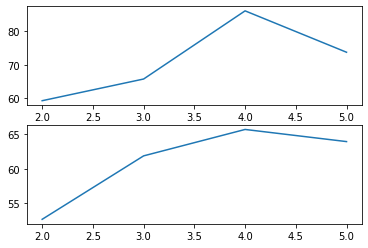

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.plot([2,3,4,5],train_accuracy)
plt.subplot(212)
plt.plot([2,3,4,5],test_accuracy)

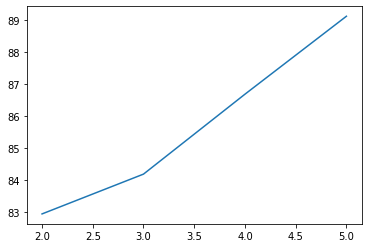

In [ ]:
import matplotlib.pyplot as plt
plt.plot([2,3,4,5],time_1)

### 3.2.3 Optimizer? Optimizer! [10 pts]
So far, we only use SGD as our optimizer. Now, pick two other optimizers, train your CNN models, and compare the performance you get. What did you see?

In [ ]:
class CNNClassifier_ada(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_ada, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.conv2 = nn.Conv2d(6,16,3)        
        self.conv3 = nn.Conv2d(16,32,3)
        self.conv4 = nn.Conv2d(32,64,3)
        self.conv5 = nn.Conv2d(64,128,3)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*4*4,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = self.pool(F.relu(self.conv2(y_pred)))
      y_pred = F.relu(self.conv3(y_pred))
      y_pred = F.relu(self.conv4(y_pred))
      y_pred = self.pool(F.relu(self.conv5(y_pred)))
      y_pred = y_pred.view(-1,128*4*4)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_ada(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adagrad(model.parameters())

for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1236.6555669307709
Epcoh 1: 982.8993709683418
Epcoh 2: 883.0274670124054
Epcoh 3: 823.5626972317696
Epcoh 4: 780.1635112166405
Epcoh 5: 746.6397703886032
Epcoh 6: 719.2660573124886
Epcoh 7: 695.1388225853443
Epcoh 8: 673.7118336558342
Epcoh 9: 655.0523284077644


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(35925, device='cuda:0')
tensor(6850, device='cuda:0')
Training accuracy: 71.8499984741211, Testing accuracy: 68.5


In [ ]:
class CNNClassifier_adam(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_adam, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.conv2 = nn.Conv2d(6,16,3)        
        self.conv3 = nn.Conv2d(16,32,3)
        self.conv4 = nn.Conv2d(32,64,3)
        self.conv5 = nn.Conv2d(64,128,3)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*4*4,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.conv1(x))
      y_pred = self.pool(F.relu(self.conv2(y_pred)))
      y_pred = F.relu(self.conv3(y_pred))
      y_pred = F.relu(self.conv4(y_pred))
      y_pred = self.pool(F.relu(self.conv5(y_pred)))
      y_pred = y_pred.view(-1,128*4*4)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_adam(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adam(model.parameters())

for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')

Epcoh 0: 1251.6062424778938
Epcoh 1: 956.0297716856003
Epcoh 2: 813.7990455627441
Epcoh 3: 716.0887127220631
Epcoh 4: 644.8697186112404
Epcoh 5: 591.8074560463428
Epcoh 6: 542.0932683944702
Epcoh 7: 504.43871626257896
Epcoh 8: 465.3019246906042
Epcoh 9: 430.5632241368294


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(41230, device='cuda:0')
tensor(7013, device='cuda:0')
Training accuracy: 82.45999908447266, Testing accuracy: 70.12999725341797


### 3.2.4 Improve Your Model [10 pts]
Again, we want you to play with your model a bit harder, and improve it. You are free to use everything you can find in the documents (`BatchNorm`, `SeLU`, etc), as long as it is not a **predefined network architectures in PyTorch package**. You can also implement some famous network architectures to push the performance. 

(A simple network with 5-6 `nn.Conv2d` can give you at least 70% accuracy on testing set).

In [ ]:
class CNNClassifier_ImproveModel(nn.Module):
    
    def __init__(self, D_in, D_out):
        super(CNNClassifier_ImproveModel, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(6,16,3)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(16,32,3)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(32,64,3)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.conv5 = nn.Conv2d(64,128,3)
        self.bn5 = nn.BatchNorm2d(num_features=128)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*4*4,D_out)

        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
      y_pred = F.relu(self.bn1(self.conv1(x)))
      y_pred = self.pool(F.relu(self.bn2(self.conv2(y_pred))))
      y_pred = F.relu(self.bn3(self.conv3(y_pred)))
      y_pred = F.relu(self.bn4(self.conv4(y_pred)))
      y_pred = self.pool(F.relu(self.bn5(self.conv5(y_pred))))
      y_pred = y_pred.view(-1,128*4*4)
      y_pred = self.linear1(y_pred)
      return y_pred

epoch = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNClassifier_ImproveModel(n_input,n_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adam(model.parameters())

for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      print(f'Epcoh {e}: {loss_epoch}')
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1050.9518062472343
Epcoh 1: 762.9772153496742
Epcoh 2: 639.1645004153252
Epcoh 3: 559.3497884571552
Epcoh 4: 496.9156074821949
Epcoh 5: 439.3301089257002
Epcoh 6: 394.45936922729015
Epcoh 7: 354.3145027756691
Epcoh 8: 314.2956321835518
Epcoh 9: 281.7990612834692


In [ ]:
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
train_accuracy.append(train_acc)
test_accuracy.append(test_acc)

tensor(45620, device='cuda:0')
tensor(7589, device='cuda:0')
Training accuracy: 91.23999786376953, Testing accuracy: 75.88999938964844
